In [85]:
"""Notebook settings and imports."""

%load_ext autoreload
%autoreload 2
# %flow mode reactive

import os

from dataclasses import dataclass, field
from typing import Callable, List, Optional, Tuple, Union

import matplotlib as mpl
import numpy as np
import pandas as pd
import torch as t

from einops import asnumpy, einsum, rearrange, reduce, repeat, pack, parse_shape, unpack
from einops.layers.torch import Rearrange, Reduce
from jaxtyping import Float, Int
from matplotlib import pyplot as plt
from plotly import express as px
from plotly import graph_objects as go
from plotly import io as pio
from rich import print as rprint
import seaborn as sns
from torch import nn, optim, Tensor
from torch.nn import functional as F
from tqdm.notebook import tqdm

from toy_cis.models import CisConfig, Cis
from toy_cis.plot import plot_weight_bars, plot_input_output_response
from toy_cis.util import threshold_matrix, in_out_response


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
"""Set KMP_DUPLICATE_LIB_OK=TRUE to avoid MKL errors when plotting with mpl"""

os.environ["KMP_DUPLICATE_LIB_OK"] = "True"
plt.rcParams.update({"font.size": 13})

In [3]:
"""Set torch device."""

device = t.device("cuda" if t.cuda.is_available() else "cpu")
# device = t.device("cpu")  # small toy models have lower loss and are faster via cpu
device_name = t.cuda.get_device_name(0) if t.cuda.is_available() else "cpu"
print(f"{device_name=}")

device_name='NVIDIA GeForce RTX 3090'


## simple-relu

Target: 
$$
y = ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x) \\
y' = W_2h
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$ 

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

### training

In [80]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [81]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

simple_relu_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=40,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)

simple_relu = Cis(simple_relu_cfg, device=device).to(device)

batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(simple_relu.parameters())

losses = train(
    simple_relu,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

[0.001588527811691165,
 0.0009322797413915396,
 0.0011064900318160653,
 0.0011308054672554135,
 0.0011117829708382487,
 0.0011249907547608018,
 0.0013216292718425393,
 0.0010361536405980587,
 0.0011675655841827393,
 0.0011838488280773163,
 0.0010860319016501307]

### viz

#### input-output response

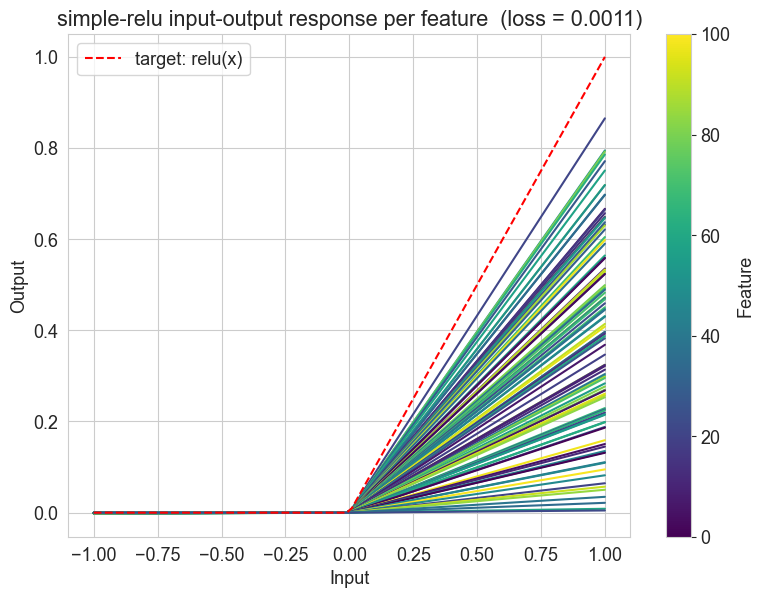

In [82]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(simple_relu, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(f"simple-relu input-output response per feature  (loss = {losses[-1]:.4f})")
ax.legend()

#### weights

l1_weights.shape=(40, 100)


Text(0.5, 1.0, 'simple-relu feature weights per neuron')

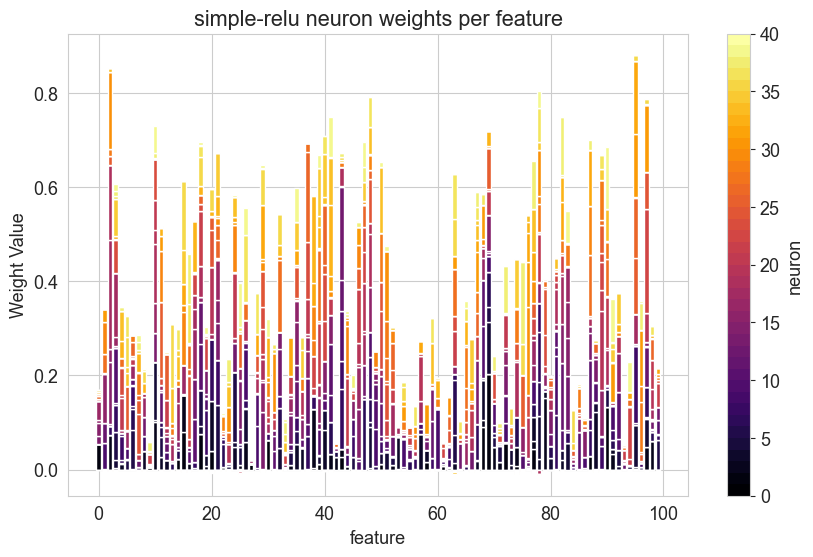

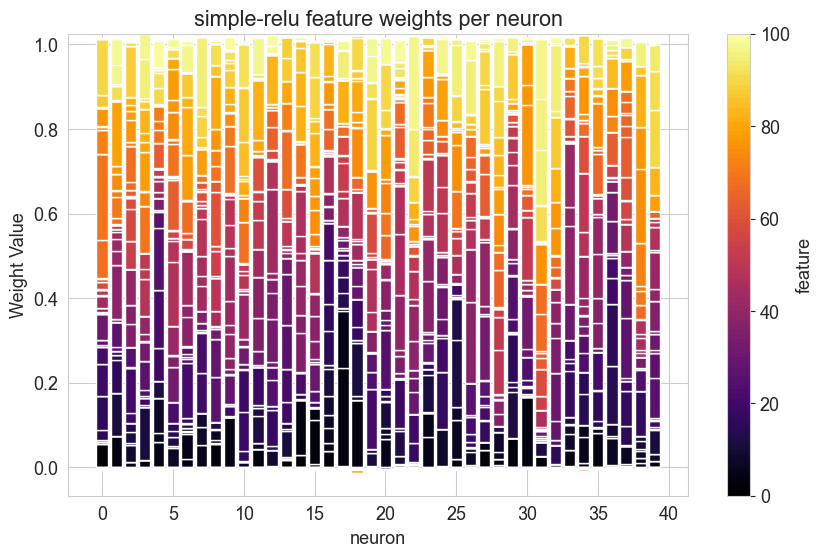

In [7]:
"""Plot weights for neurons per feature, and for features per neuron."""

l1_weights = threshold_matrix(asnumpy(simple_relu.W1).squeeze(), threshold=0.01)
l2_weights = threshold_matrix(asnumpy(simple_relu.W2).squeeze(), threshold=0.01)
l1_weights = einsum(l1_weights, l2_weights, "neuron feature, feature neuron-> neuron feature")

print(f"{l1_weights.shape=}")

fig = plot_weight_bars(l1_weights, xax="feature")
fig.get_axes()[0].set_title("simple-relu neuron weights per feature")

fig = plot_weight_bars(l1_weights.T, xax="neuron")
fig.get_axes()[0].set_title("simple-relu feature weights per neuron")

Text(0.5, 1.0, 'Distribution of nonzero neuron weights per feature')

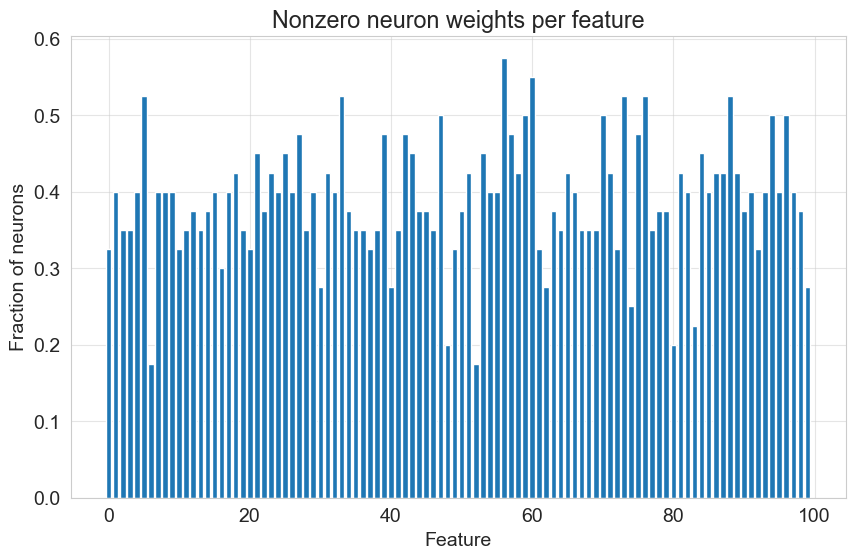

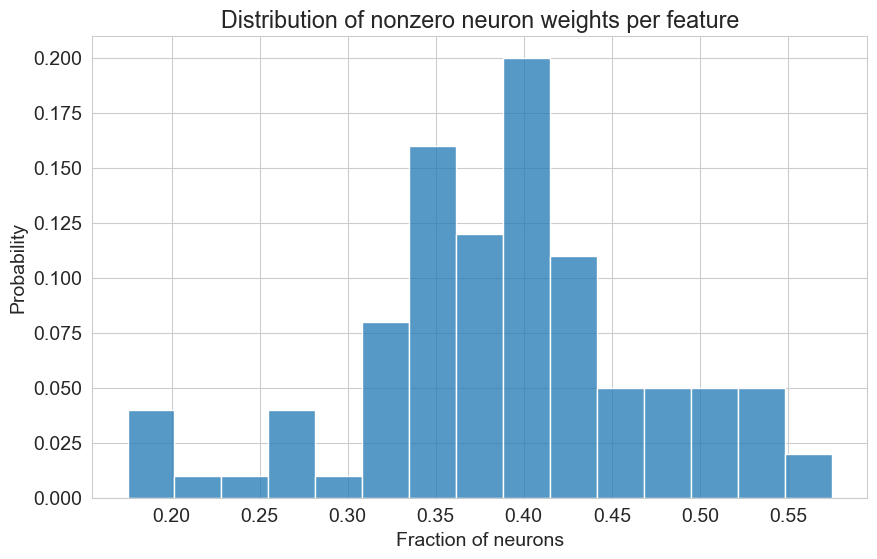

In [25]:
"""Plot nonzero neuron weights per feature."""

nonzero_counts = np.count_nonzero(l1_weights, axis=0)  # nonzero neuron weights per feature
frac_nonzero = nonzero_counts / simple_relu.cfg.n_hidden

# Plot nonzero_counts per feature
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(range(len(nonzero_counts)), frac_nonzero)
ax.set_xlabel("Feature")
ax.set_ylabel("Fraction of neurons")
ax.set_title("Nonzero neuron weights per feature")
ax.grid(True, alpha=0.5)

# Plot distribution of nonzero_counts
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(frac_nonzero, bins=15, stat="probability", ax=ax)
ax.set_xlabel("Fraction of neurons")
ax.set_title("Distribution of nonzero neuron weights per feature")
# ax.set_xticks(range(8, 27, 2))

#### how many features are learned? or, what is loss per feature?

Text(0.5, 1.0, 'Loss per feature, for 1000 examples per feature')

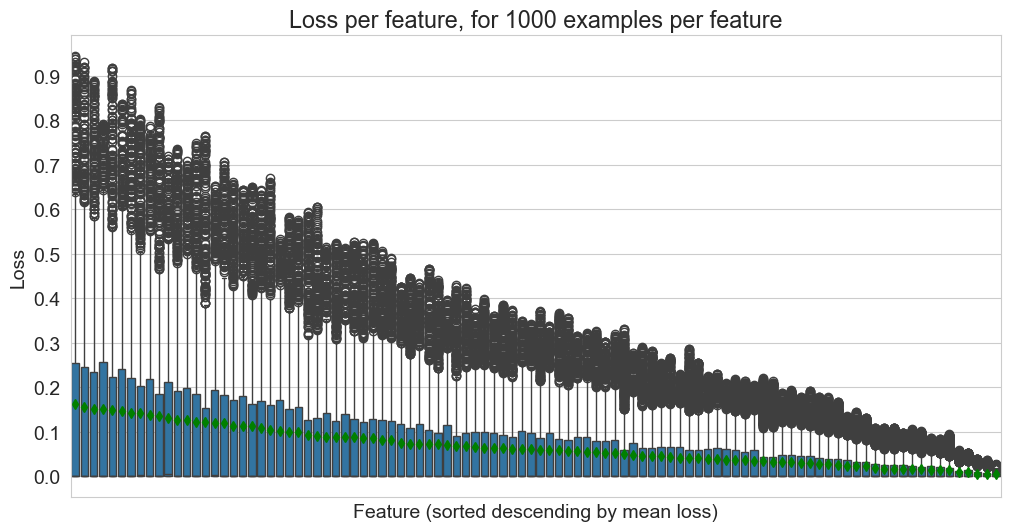

In [26]:
"""Box of loss per feature, ranked from highest mean loss to lowest."""

n_examples = 1000
losses = t.zeros((n_examples, simple_relu.cfg.n_feat), device=device)

# Activate only one feature at a time and calculate loss for that feature; loop for all features
for feat in range(simple_relu.cfg.n_feat):
    x = t.zeros(
        n_examples, simple_relu.cfg.n_instances, simple_relu.cfg.n_feat, device=device
    )
    # make only feat-th feature active
    x[:, :, feat] = rearrange((t.rand(n_examples) * 2 - 1), "n -> n 1")
    y_true = t.relu(x)
    y = simple_relu.forward(x)
    losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()

sorted_idxs = t.argsort(reduce(losses, "example feat -> feat", "mean"), descending=True)
losses = losses[:, sorted_idxs]
sorted_idxs = asnumpy(sorted_idxs)
df = pd.DataFrame(asnumpy(losses))
df_melted = df.melt(var_name="Feature", value_name="Loss")

fig, ax = plt.subplots(figsize=(12, 6))
meanprops = dict(marker="d", markerfacecolor="green", markeredgecolor="green", markersize=5)
sns.boxplot(data=df_melted, x="Feature", y="Loss", ax=ax, showmeans=True, meanprops=meanprops)

ax.set_xticks([], [])  # Hide x-axis labels if too many
ax.set_xlabel("Feature (sorted descending by mean loss)")
ax.set_ylabel("Loss")
ax.set_yticks(np.arange(0, 1, 0.1))
ax.set_title(f"Loss per feature, for {n_examples} examples per feature")

Text(0.5, 1.0, 'Distribution of mean loss per feature')

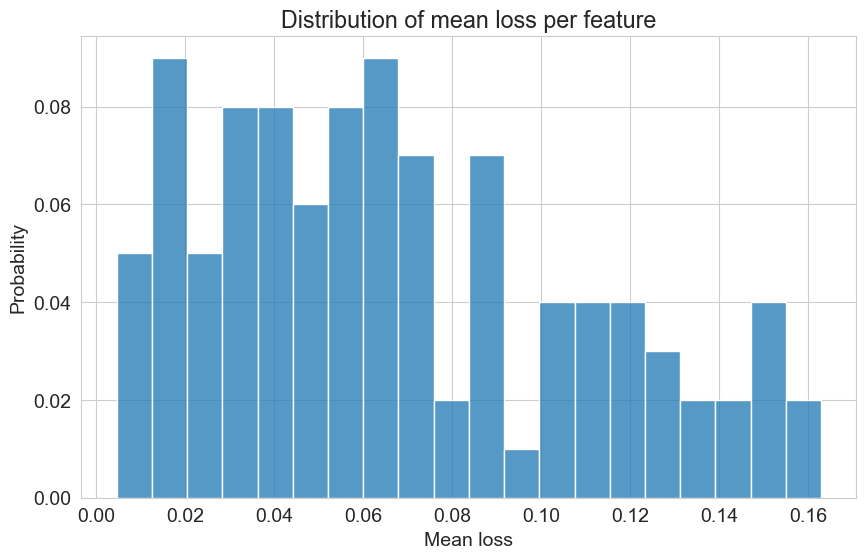

In [27]:
"""Distribution of mean loss per feature."""

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    asnumpy(reduce(losses, "example feat -> feat", "mean")), bins=20, stat="probability", ax=ax
)
ax.set_xlabel("Mean loss")
ax.set_title("Distribution of mean loss per feature")

#### loss and polysemanticity as a function of sparsity

- Per sparsity level (e.g. [0.05 : 0.95 : 0.05]) plot, as ridge plots (1 plot/row per sparsity level)
  
  1. polysemanticity (distribution of nonzero weights per feature)
  
  2. distribution of loss per feature (with final loss at end of training in figure title)


In [28]:
"""Get polysemanticity and loss for set of sparsities."""

sparsities = np.round(np.linspace(0.01, 0.99, 20), 2)
batch_sz = 256
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10

poly_data = []  # will become a df with cols ["sparsity", "fraction_nonzero"]
loss_data = []  # will become a df with cols ["sparsity", "mean_loss"]

pbar = tqdm(sparsities, desc="Training over sparsities")
for s in pbar:
    # Train model.
    simple_relu = Cis(simple_relu_cfg, device=device).to(device)
    optimizer = t.optim.Adam(simple_relu.parameters())
    losses = train(
        simple_relu,
        batch_sz,
        s,
        feat_importance,
        loss_fn,
        optimizer,
        n_steps,
        logging_freq
    )

    # Get polysemanticity of neurons (frac of nonzero neuron weights per feature).
    l1_weights = threshold_matrix(asnumpy(simple_relu.W1).squeeze(), threshold=0.01)
    l2_weights = threshold_matrix(asnumpy(simple_relu.W2).squeeze(), threshold=0.01)
    l1_weights = einsum(l1_weights, l2_weights, "neuron feature, feature neuron-> neuron feature")
    nonzero_counts = np.count_nonzero(l1_weights, axis=0)  # nonzero neuron weights per feature
    frac_nonzero = nonzero_counts / simple_relu.cfg.n_hidden
    for val in frac_nonzero:
        poly_data.append({"sparsity": s, "frac_nonzero": val})

    # Get mean loss per feature.
    n_examples = 1000
    losses = t.zeros((n_examples, simple_relu.cfg.n_feat), device=device)
    # Activate only one feature at a time and calculate loss for that feature; loop for all features
    with t.no_grad():
        for feat in range(simple_relu.cfg.n_feat):
            x = t.zeros(
                n_examples, simple_relu.cfg.n_instances, simple_relu.cfg.n_feat, device=device
            )
            # make only feat-th feature active
            x[:, :, feat] = rearrange((t.rand(n_examples) * 2 - 1), "n -> n 1")
            y_true = t.relu(x)
            y = simple_relu.forward(x)
            losses[:, feat] = ((y[:, :, feat] - y_true[:, :, feat]) ** 2).ravel()
    mean_losses = asnumpy(reduce(losses, "example feat -> feat", "mean"))
    for val in mean_losses:
        loss_data.append({"sparsity": s, "mean_loss": val})


Training over sparsities:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

Training:   0%|          | 0/5000 [00:00<?, ?it/s]

C:\Users\jai\AppData\Local\Temp\ipykernel_29808\4202084967.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_poly.set_yticklabels((ax_poly.get_yticks() * len(sparsities)).round(1).astype(str))
C:\Users\jai\AppData\Local\Temp\ipykernel_29808\4202084967.py:61: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_loss.set_yticklabels((ax_loss.get_yticks() * len(sparsities)).round(1).astype(str))


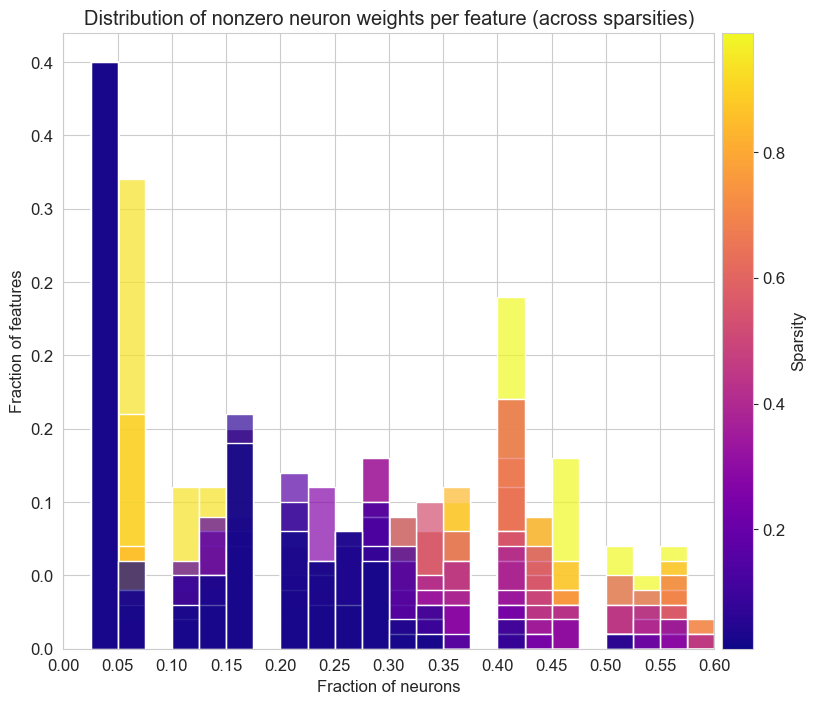

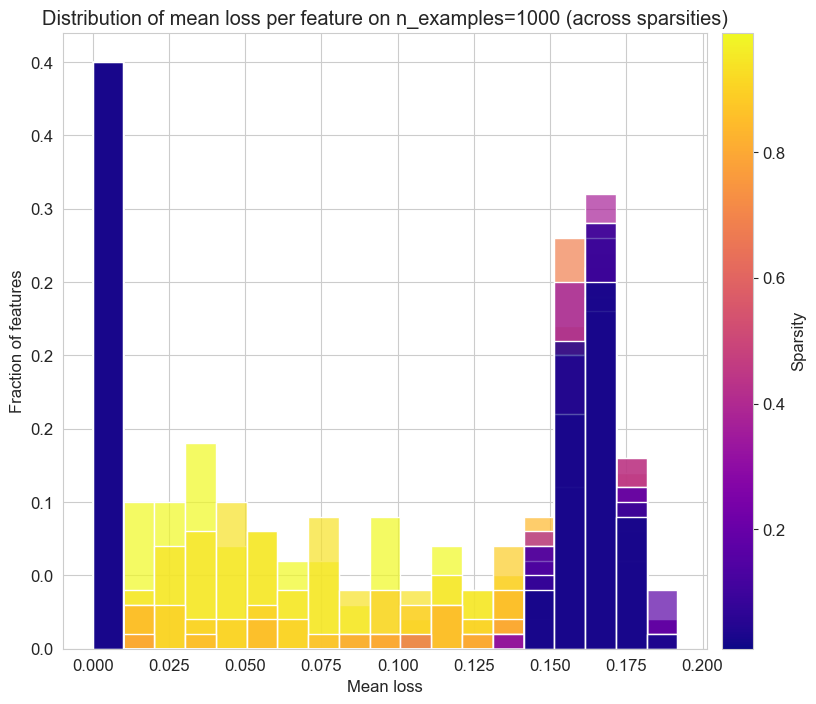

In [29]:
"""Plot polysemanticity and loss for set of sparsities."""

fig_poly, ax_poly = plt.subplots(figsize=(10, 8))
fig_loss, ax_loss = plt.subplots(figsize=(10, 8))

df_poly = pd.DataFrame(poly_data)
df_loss = pd.DataFrame(loss_data)

cmap = plt.cm.plasma
norm = mpl.colors.Normalize(vmin=df_poly["sparsity"].min(), vmax=df_poly["sparsity"].max())

# Plot polysemanticity
sns.histplot(
    data=df_poly,
    x="frac_nonzero",
    hue="sparsity",
    fill=True,
    alpha=0.7,
    linewidth=1,
    ax=ax_poly,
    multiple="layer",
    palette="plasma",
    legend=False,
    stat="probability",
    binwidth=0.025
)

# prettify
ax_poly.set_ylabel("Fraction of features")
ax_poly.set_xlabel("Fraction of neurons")
ax_poly.set_title("Distribution of nonzero neuron weights per feature (across sparsities)")
ax_poly.set_xticks(np.arange(0, 0.61, 0.05))
ax_poly.set_xlim(0, 0.6)
ax_poly.set_yticklabels((ax_poly.get_yticks() * len(sparsities)).round(1).astype(str))

# add colorbar
sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig_poly.colorbar(sm, ax=ax_poly, pad=0.01)
cbar.set_label("Sparsity")

# Plot loss
sns.histplot(
    data=df_loss,
    x="mean_loss",
    hue="sparsity",
    fill=True,
    alpha=0.7,
    linewidth=1,
    ax=ax_loss,
    multiple="layer",
    palette="plasma",
    legend=False,  # ✅ Remove the legend
    stat="probability",
    binwidth=0.01
)

# prettify
ax_loss.set_ylabel("Fraction of features")
ax_loss.set_xlabel("Mean loss")
ax_loss.set_yticklabels((ax_loss.get_yticks() * len(sparsities)).round(1).astype(str))
ax_loss.set_title(f"Distribution of mean loss per feature on {n_examples=} (across sparsities)")

# add colorbar
sm_loss = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
sm_loss.set_array([])  # Needed to set up the colorbar correctly
cbar_loss = fig_loss.colorbar(sm_loss, ax=ax_loss, pad=0.02)
cbar_loss.set_label("Sparsity")

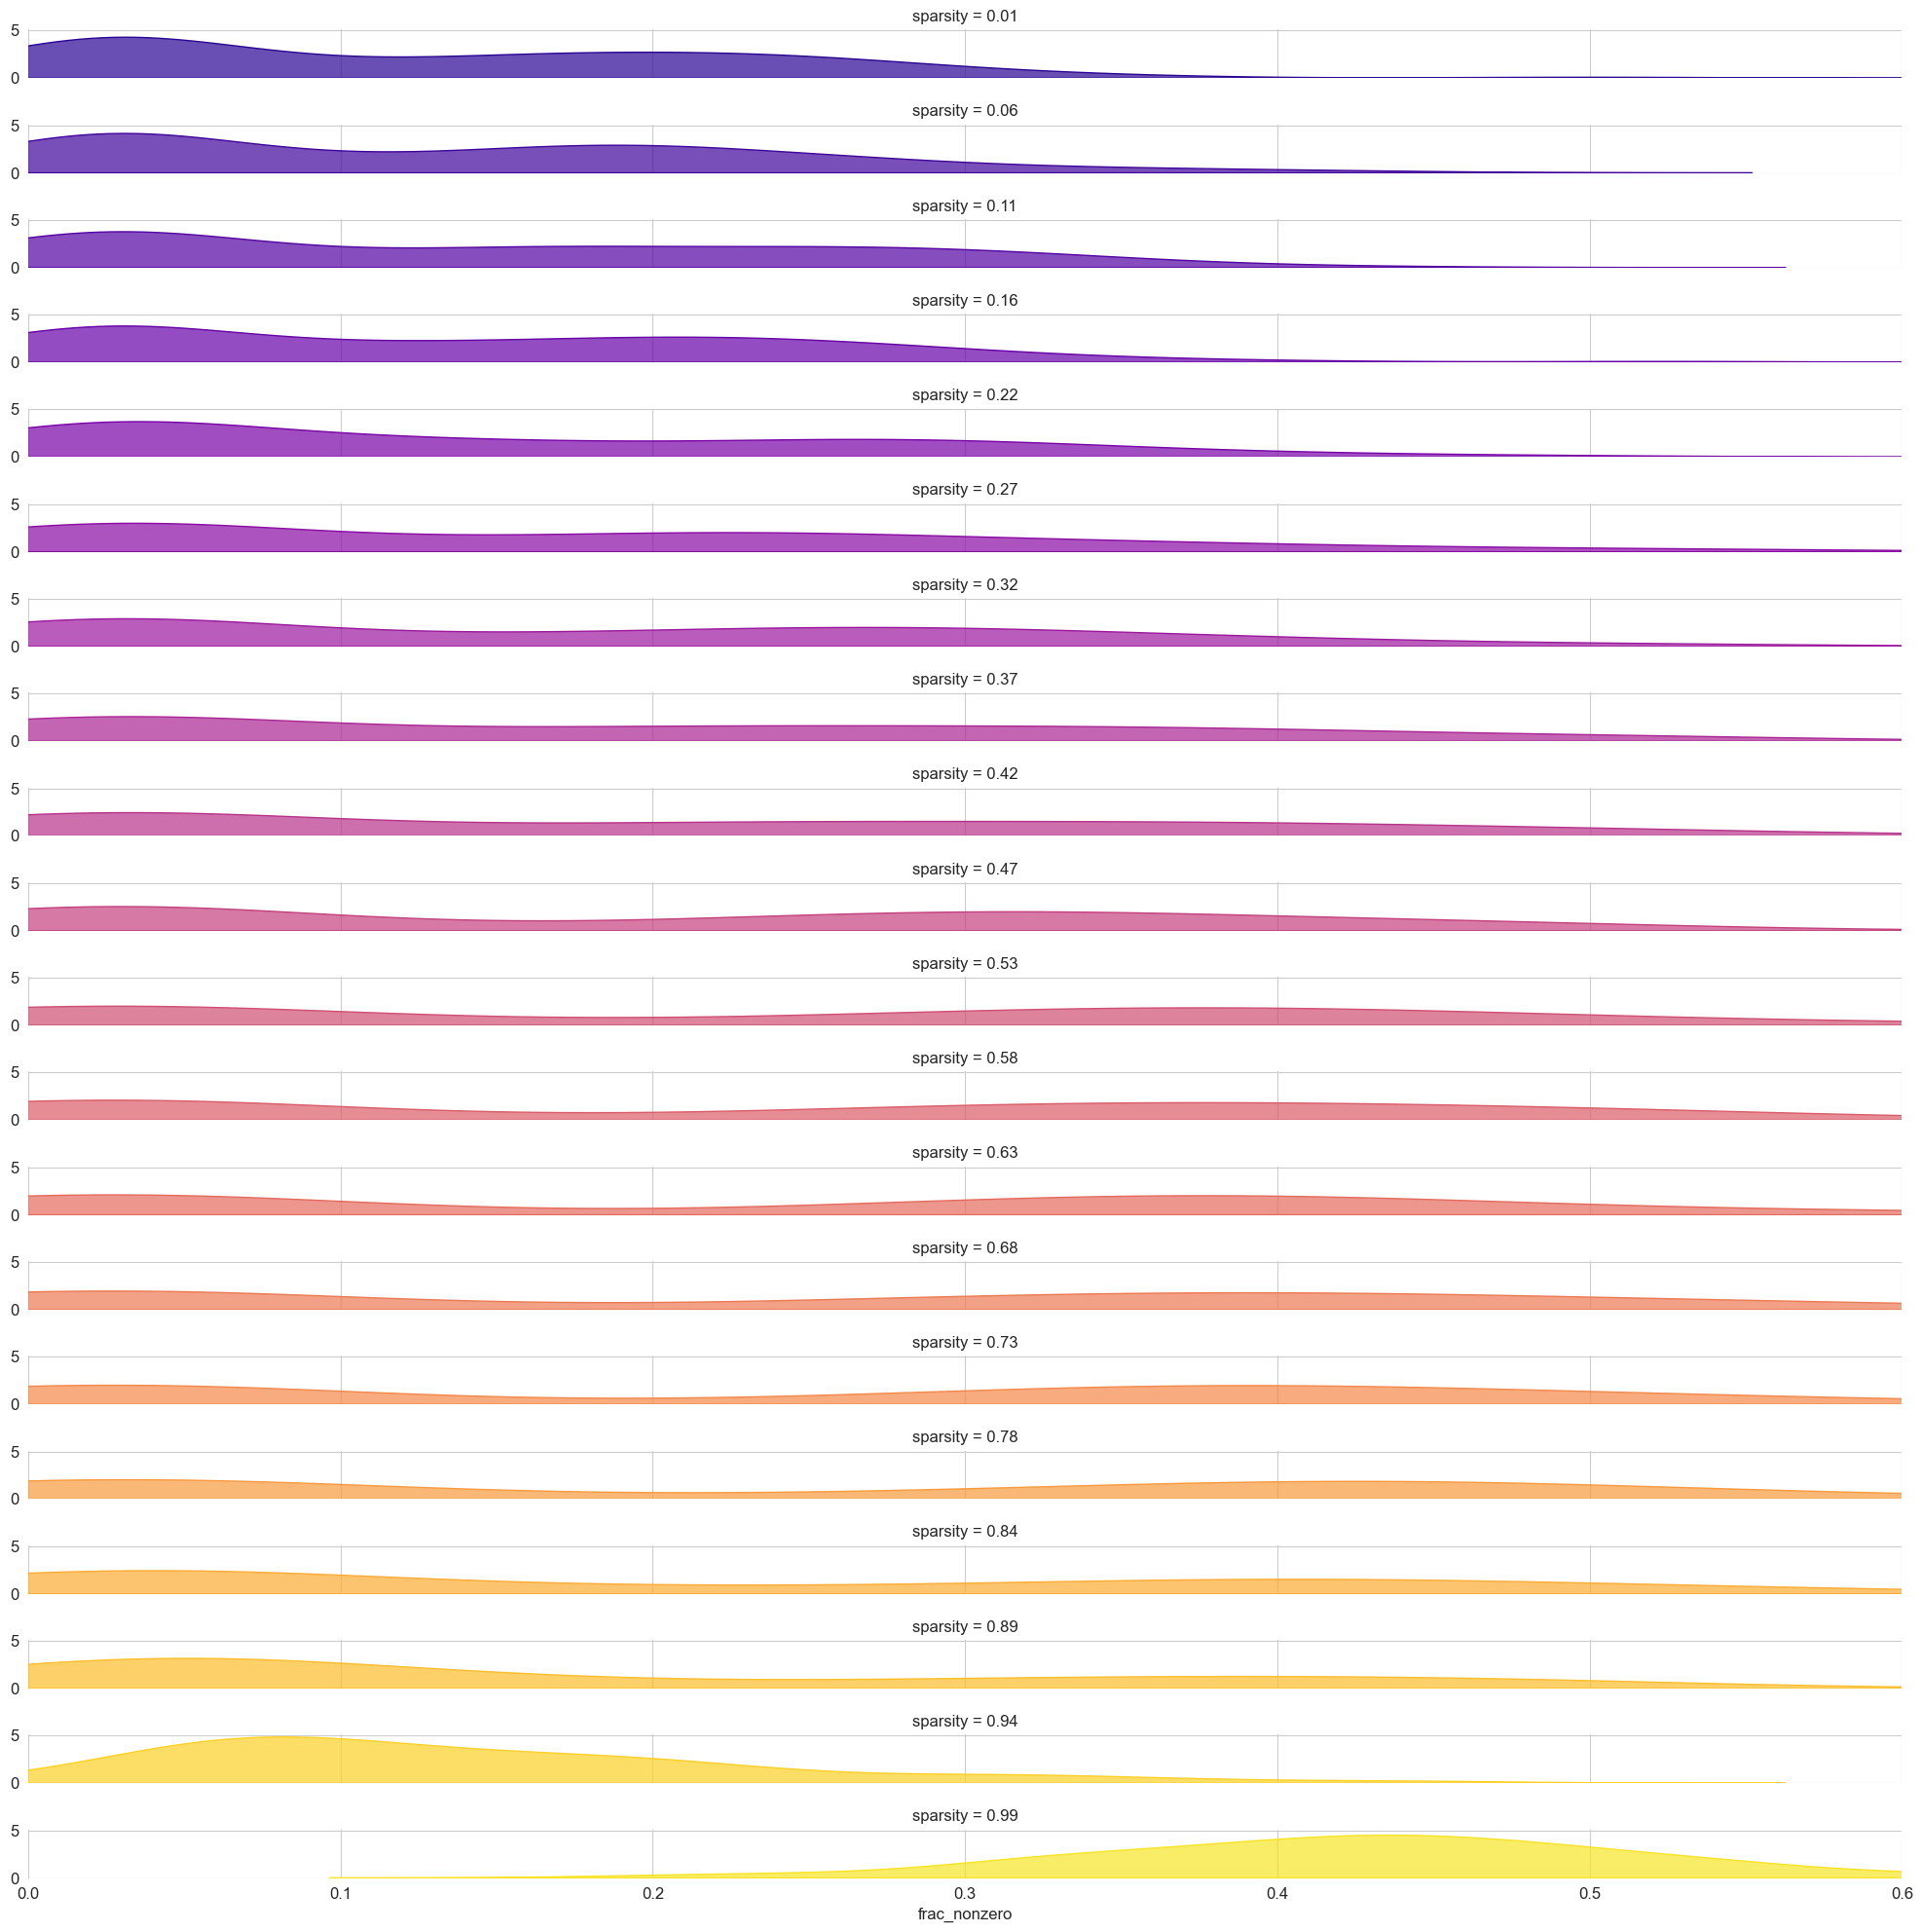

In [30]:
"""Could also potentially plot polysemanticity (and loss) per sparsity level as facetgrid
where each sparsity level has its own axis - but this doesn't look as good imo
"""

g = sns.FacetGrid(
    df_poly,
    row="sparsity",
    hue="sparsity",
    aspect=20,  # wide aspect so we can see the ridgeline shape
    height=1,  # each subplot’s height in inches
    palette="plasma",   
    sharex=True,        
    sharey=True
)

g.map(
    sns.kdeplot,
    "frac_nonzero",
    fill=True,
    alpha=0.7, 
)
g.set(ylabel=None)
g.set(xlim=(0, 0.6))
g.despine(left=True, bottom=True)


## simple-relu-onehot

Target: 
$$
y = ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x) \\
y' = W_2h
$$

Input (one-hot vector):

$$
x = \text{randint}(-1, 1) \\
$$ 

Loss (weighted mse):

$$
\text{WMSE} = \frac{1}{N} \sum_{i=1}^{N} w_i \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
\text{where} \\[2ex]
w_i =
\begin{cases}
10, & \text{if } y_{\text{true},i} = 1, \\
1, & \text{otherwise}.
\end{cases}
$$



### training

In [20]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    x = t.zeros(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device)
    active_positions = t.randint(
            0, model.cfg.n_feat, (batch_sz, model.cfg.n_instances), device=device
    )
    active_values = t.randint(0, 2, (batch_sz, model.cfg.n_instances), device=device) * 2.0 - 1
    
    # Create index tensors for vectorized assignment
    batch_idx = t.arange(batch_sz, device=device).view(-1, 1).expand(-1, model.cfg.n_instances)
    instance_idx = t.arange(model.cfg.n_instances, device=device).expand(batch_sz, -1)
    
    # Vectorized assignment using advanced indexing
    x[batch_idx, instance_idx, active_positions] = active_values
    
    return x, t.relu(x)

def loss_fn(y: Float[Tensor, "batch inst feat"], y_true: Float[Tensor, "batch inst feat"]) -> Float:
    active_weight, inactive_weight = 10, 1
    weights = t.where(y_true == 1, active_weight, inactive_weight)
    wmse = weights * (y - y_true) ** 2
    return reduce(wmse, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz)
        y = model.forward(x)
        loss = loss_fn(y, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [21]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

simple_relu_onehot_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=40,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
)

simple_relu_onehot = Cis(simple_relu_onehot_cfg, device=device).to(device)


batch_sz = 256
n_steps = 4000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(simple_relu_onehot.parameters())

losses = train(
    simple_relu_onehot,
    batch_sz,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

[0.05074930191040039,
 0.007389452308416367,
 0.006892138160765171,
 0.006790755782276392,
 0.0072038015350699425,
 0.006613806821405888,
 0.006029877346009016,
 0.006836121901869774,
 0.006756884977221489,
 0.006576527841389179,
 0.006264807656407356]

### viz

#### input-output response

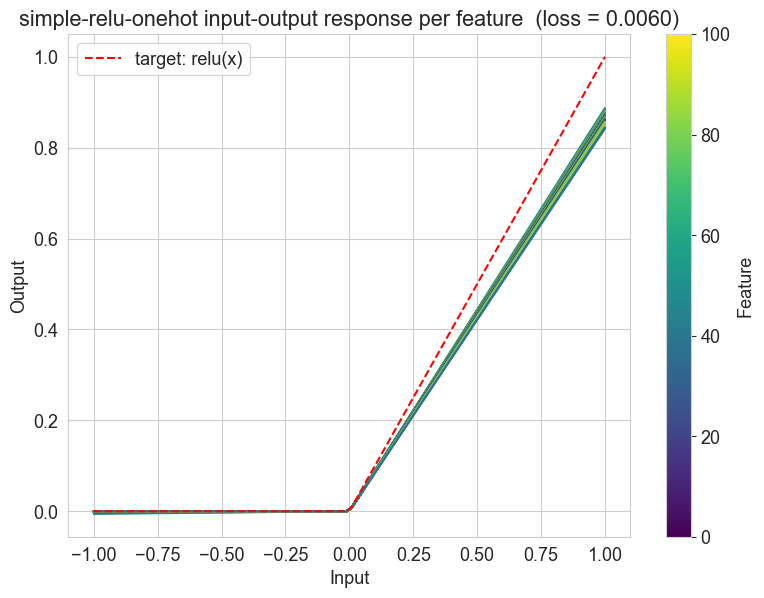

In [11]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(simple_relu_onehot, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(asnumpy(vals), asnumpy(t.relu(vals)), color="red", linestyle="--", label="target: relu(x)")
ax.set_title(f"simple-relu-onehot input-output response per feature  (loss = {losses[-1]:.4f})")
ax.legend()

#### weights

l1_weights.shape=(40, 100)


Text(0.5, 1.0, 'simple-relu-onehot feature weights per neuron')

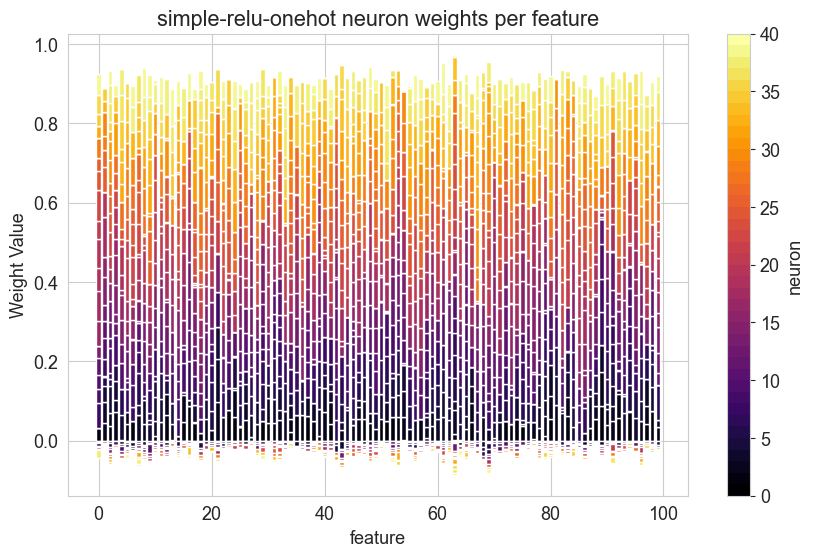

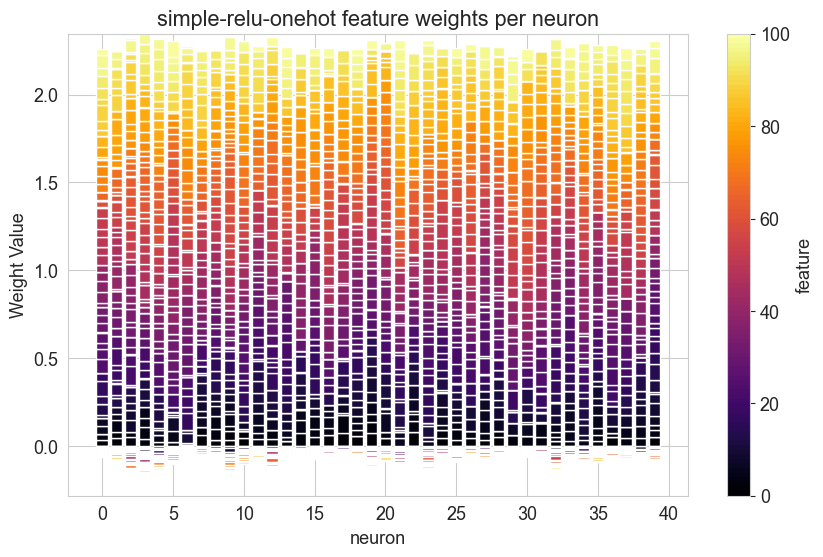

In [22]:
"""Plot weights for neurons per feature, and for features per neuron."""

l1_weights = threshold_matrix(asnumpy(simple_relu_onehot.W1).squeeze(), threshold=0.01)
l2_weights = threshold_matrix(asnumpy(simple_relu_onehot.W2).squeeze(), threshold=0.01)
l1_weights = einsum(l1_weights, l2_weights, "neuron feature, feature neuron-> neuron feature")

print(f"{l1_weights.shape=}")

fig = plot_weight_bars(l1_weights, xax="feature")
fig.get_axes()[0].set_title("simple-relu-onehot neuron weights per feature")

fig = plot_weight_bars(l1_weights.T, xax="neuron")
fig.get_axes()[0].set_title("simple-relu-onehot feature weights per neuron")

## res-mlp-no-embed

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
h = ReLU(W_1x) \\
y' = W_2h + x
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

### training

In [87]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int, sparsity: float | Float[Tensor, "inst feat"]) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    # Randomly generate features vals, and for each, randomly set which samples are non-zero
    x = t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) * 2 - 1  # [-1, 1]
    is_active = (
        t.rand(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device) < (1 - sparsity)
    )
    x *= is_active
    return x, x + t.relu(x)

def loss_fn(y, y_true, i):
    return reduce((y - y_true) ** 2 * i, "batch inst feat -> ", "mean")

def train(
    model: Cis,
    batch_sz: int,
    feat_sparsity: float | Float[Tensor, "inst feat"],
    feat_importance: float | Float[Tensor, "inst feat"],
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""    
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz, feat_sparsity)
        y = model.forward(x)
        loss = loss_fn(y, y_true, feat_importance)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [24]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

res_mlp_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=40,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    # We_and_Wu=True,
    # We_dim=1000
)

res_mlp = Cis(res_mlp_cfg, device=device).to(device)

batch_sz = 128
feat_sparsity = 0.99
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(res_mlp.parameters())

losses = train(
    res_mlp,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

[0.0011352301808074117,
 0.001246826141141355,
 0.001204829546622932,
 0.0008095627999864519,
 0.0009086689678952098,
 0.0006773262866772711,
 0.0010795887792482972,
 0.0009127180092036724,
 0.0007615271024405956,
 0.0008764558006078005,
 0.000754976412281394]

### viz

#### input-output response

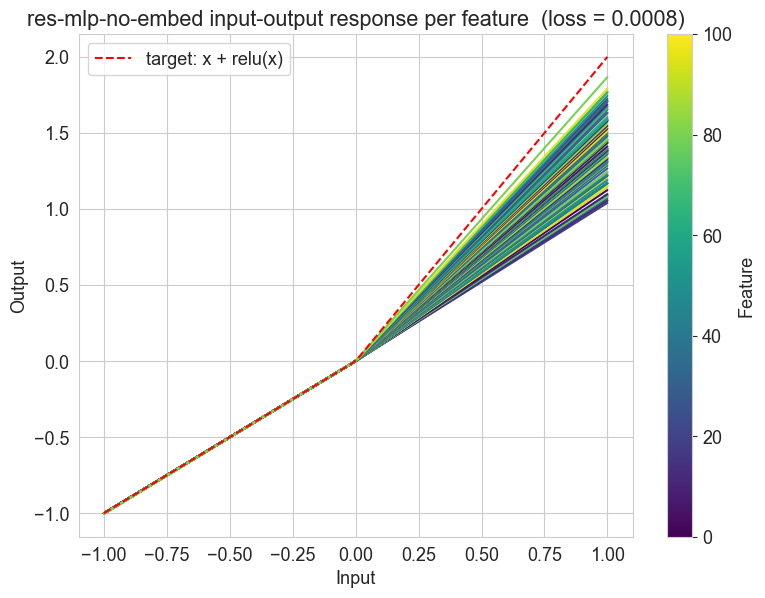

In [25]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(res_mlp, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(
    asnumpy(vals), asnumpy(vals + t.relu(vals)), color="red", linestyle="--", label="target: x + relu(x)"
)
ax.set_title(f"res-mlp-no-embed input-output response per feature  (loss = {losses[-1]:.4f})")
ax.legend()

#### weights

l1_weights.shape=(40, 100)


Text(0.5, 1.0, 'res-mlp-no-embed weights per neuron')

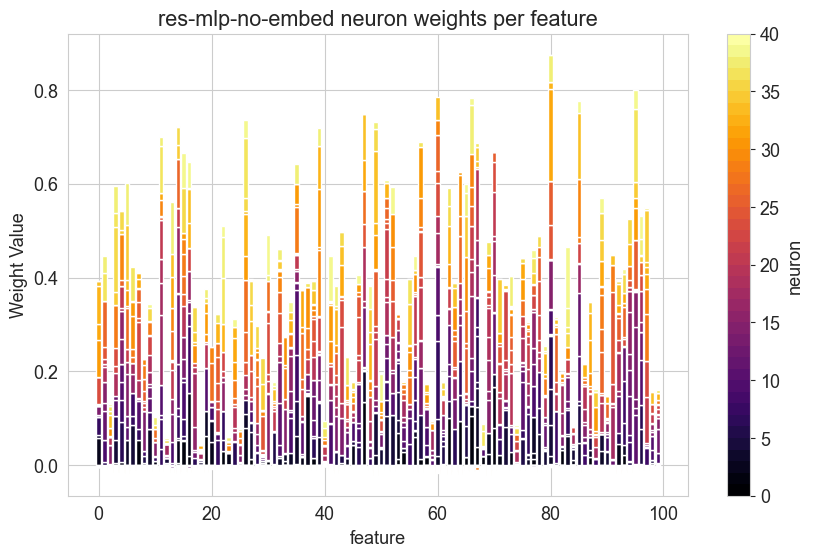

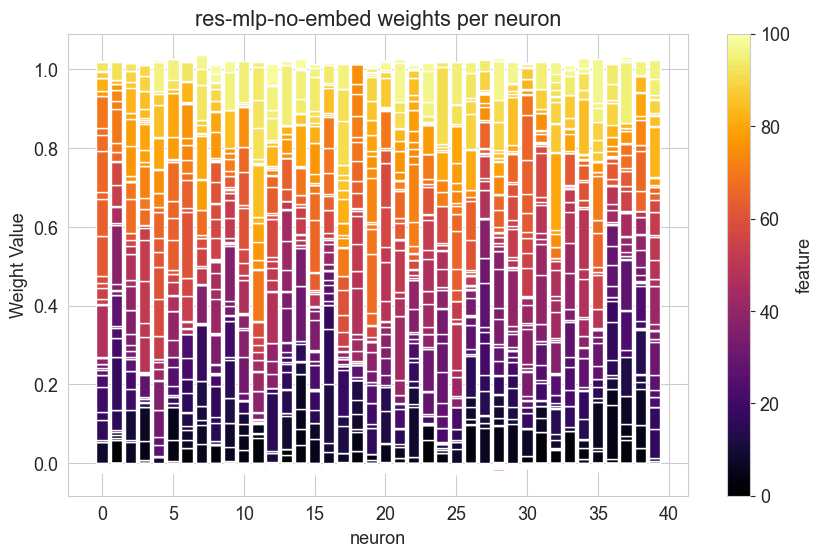

In [26]:
"""Plot weights for neurons per feature, and for features per neuron."""

l1_weights = threshold_matrix(asnumpy(res_mlp.W1).squeeze(), threshold=0.01)
l2_weights = threshold_matrix(asnumpy(res_mlp.W2).squeeze(), threshold=0.01)
l1_weights = einsum(l1_weights, l2_weights, "neuron feature, feature neuron-> neuron feature")

print(f"{l1_weights.shape=}")

fig = plot_weight_bars(l1_weights, xax="feature")
fig.get_axes()[0].set_title("res-mlp-no-embed neuron weights per feature")

fig = plot_weight_bars(l1_weights.T, xax="neuron")
fig.get_axes()[0].set_title("res-mlp-no-embed weights per neuron")

## res-mlp

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
e = W_e x \\
h = ReLU(W_1 e) \\
u = W_2 h + x
y' = W_u u
$$

Input (sparsity=0.99, so feature_probability=0.01 for each feature on each example):

$$
x = \text{rand}(-1, 1) \\
$$

Loss (mse):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
$$

### training

In [149]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

res_mlp_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=40,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000
)

res_mlp = Cis(res_mlp_cfg, device=device).to(device)

batch_sz = 256
feat_sparsity = 0.99
feat_importance = 1
n_steps = 4000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(res_mlp.parameters(), lr=5e-4)

losses = train(
    res_mlp,
    batch_sz,
    feat_sparsity,
    feat_importance,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

[0.0023659078869968653,
 0.0010755575494840741,
 0.0009419311536476016,
 0.0009042703895829618,
 0.0009617310715839267,
 0.0007720924913883209,
 0.0008871391182765365,
 0.0008466443396173418,
 0.0009122801129706204,
 0.0006267320713959634,
 0.0008215633570216596]

### viz

#### input-output response

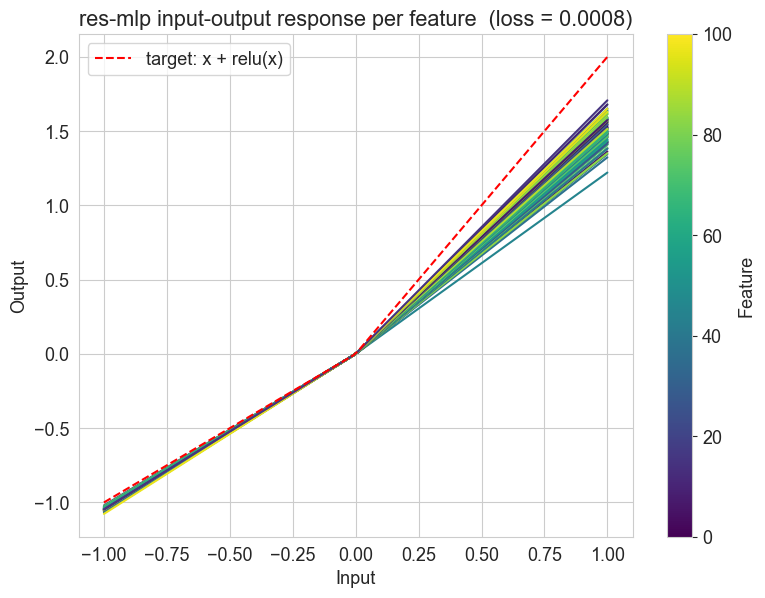

In [150]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(res_mlp, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(
    asnumpy(vals), asnumpy(vals + t.relu(vals)), color="red", linestyle="--", label="target: x + relu(x)"
)
ax.set_title(f"res-mlp input-output response per feature  (loss = {losses[-1]:.4f})")
ax.legend()

#### weights

l1_weights.shape=(40, 100)


Text(0.5, 1.0, 'res-mlp weights per neuron')

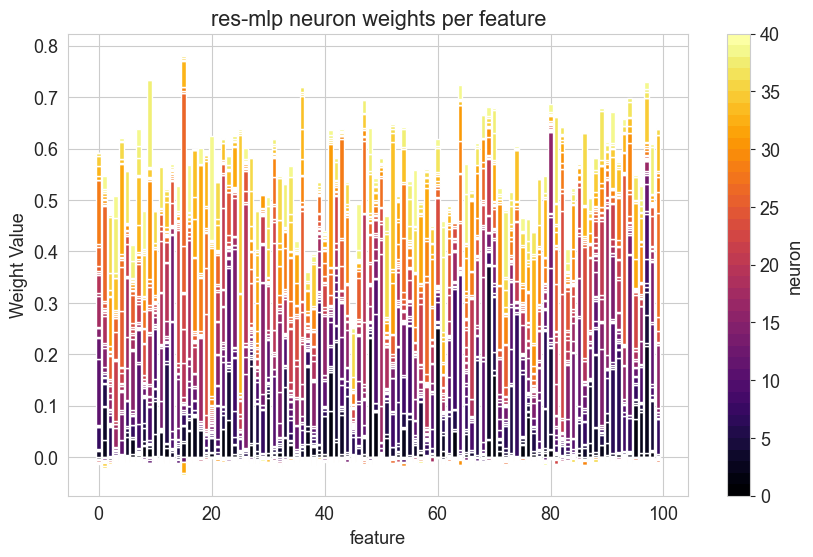

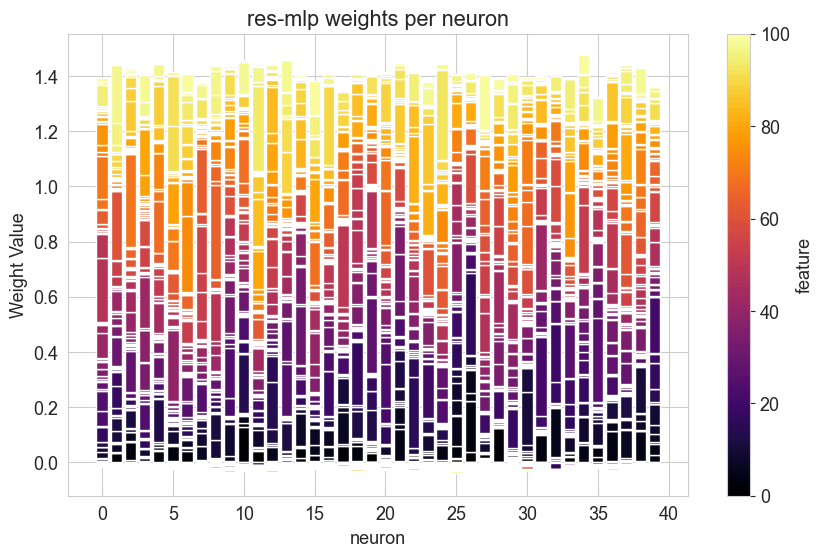

In [151]:
"""Plot weights for neurons per feature, and for features per neuron."""

l1_weights = threshold_matrix(asnumpy(res_mlp.W1).squeeze(), threshold=0.01)
l1_weights = einsum(l1_weights, asnumpy(res_mlp.We.squeeze()), "neuron emb, emb feat-> neuron feat")
l2_weights = threshold_matrix(asnumpy(res_mlp.W2).squeeze(), threshold=0.01)
l2_weights = einsum(asnumpy(res_mlp.Wu.squeeze()), l2_weights, "feat emb, emb neuron-> feat neuron")

l1_weights = einsum(l1_weights, l2_weights, "neuron feature, feature neuron-> neuron feature")

print(f"{l1_weights.shape=}")

fig = plot_weight_bars(l1_weights, xax="feature")
fig.get_axes()[0].set_title("res-mlp neuron weights per feature")

fig = plot_weight_bars(l1_weights.T, xax="neuron")
fig.get_axes()[0].set_title("res-mlp weights per neuron")

## res-mlp-onehot

Target: 
$$
y = x + ReLU(x)
$$

Linear map: 

$$
e = W_e x \\
h = ReLU(W_1 e) \\
u = W_2 h + x
y' = W_u u
$$

Input (one-hot vector):

$$
x = \text{randint}(-1, 1) \\
$$

Loss (weighted mse):

$$
\text{WMSE} = \frac{1}{N} \sum_{i=1}^{N} w_i \left(y_i - y_{\text{true},i}\right)^2 \\[2ex]
\text{where} \\[2ex]
w_i =
\begin{cases}
10, & \text{if } y_{\text{true},i} = 1, \\
1, & \text{otherwise}.
\end{cases}
$$

### training

In [152]:
"""Create functions for generating batches, loss, and training."""

def gen_batch(model: Cis, batch_sz: int) -> (
    tuple[Float[Tensor, "batch inst feat"], Float[Tensor, "batch inst feat"]]
):
    """Generates a batch of x, y data."""
    x = t.zeros(batch_sz, model.cfg.n_instances, model.cfg.n_feat, device=device)
    active_positions = t.randint(
            0, model.cfg.n_feat, (batch_sz, model.cfg.n_instances), device=device
    )
    active_values = t.randint(0, 2, (batch_sz, model.cfg.n_instances), device=device) * 2.0 - 1
    
    # Create index tensors for vectorized assignment
    batch_idx = t.arange(batch_sz, device=device).view(-1, 1).expand(-1, model.cfg.n_instances)
    instance_idx = t.arange(model.cfg.n_instances, device=device).expand(batch_sz, -1)
    
    # Vectorized assignment using advanced indexing
    x[batch_idx, instance_idx, active_positions] = active_values

    return x, x + t.relu(x)


def loss_fn(y: Float[Tensor, "batch inst feat"], y_true: Float[Tensor, "batch inst feat"]) -> Float:
    active_weight, inactive_weight = 10, 1
    weights = t.where(y_true == 1, active_weight, inactive_weight)
    wmse = weights * (y - y_true) ** 2
    return reduce(wmse, "batch inst feat -> ", "mean")


def train(
    model: Cis,
    batch_sz: int,
    loss_fn: Callable,
    optimizer: optim.Optimizer,
    n_steps: int,
    logging_freq: int,
) -> List[Float]:
    """Trains the model for `n_steps` steps, logging loss every `logging_freq` steps."""
    losses = []

    pbar = tqdm(range(n_steps), desc="Training")
    for step in pbar:
        x, y_true = gen_batch(model, batch_sz)
        y = model.forward(x)
        loss = loss_fn(y, y_true)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Log progress
        if step % logging_freq == 0 or (step + 1 == n_steps):
            losses.append(loss.item())
            pbar.set_postfix({"loss": f"{loss.item():.4f}"})
    
    return losses

In [153]:
"""Create and train model."""

layer_act_fns = [t.relu, lambda x: x]

res_mlp_cfg = CisConfig(
    n_instances=1,
    n_feat=100,
    n_hidden=40,
    act_fn=layer_act_fns,
    b1=None,
    b2=None,
    skip_cnx=True,
    We_and_Wu=True,
    We_dim=1000
)

res_mlp = Cis(res_mlp_cfg, device=device).to(device)

batch_sz = 128
n_steps = 4000
logging_freq = n_steps // 10
optimizer = t.optim.Adam(res_mlp.parameters())

losses = train(
    res_mlp,
    batch_sz,
    loss_fn,
    optimizer,
    n_steps,
    logging_freq
)
display(losses)

Training:   0%|          | 0/4000 [00:00<?, ?it/s]

[0.005624715704470873,
 0.0026962170377373695,
 0.0025407890789210796,
 0.002043165499344468,
 0.0023746443912386894,
 0.002571230987086892,
 0.002747942227870226,
 0.0023702443577349186,
 0.0026288414373993874,
 0.0024257886689156294,
 0.0025361073203384876]

### viz

#### input-output response

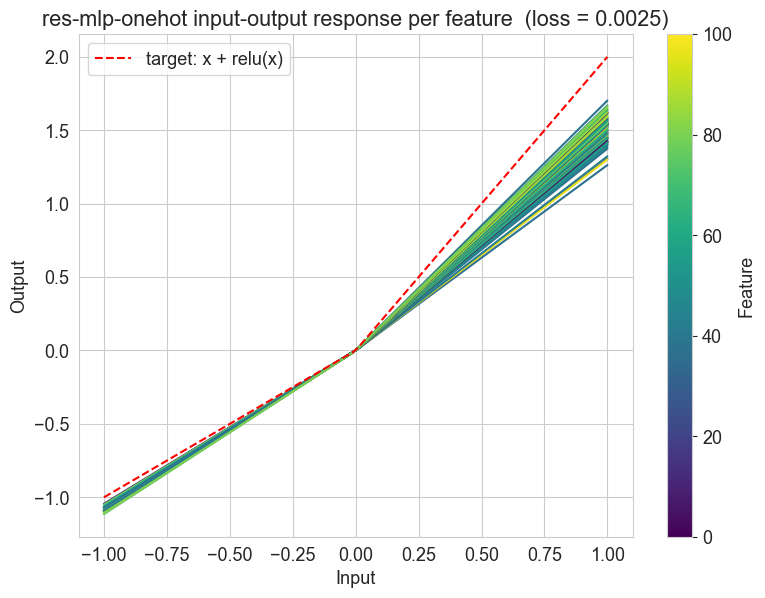

In [154]:
"""Calculate and plot input-output response."""

vals = t.linspace(-1, 1, 100, device=device)  # input values
Y = in_out_response(res_mlp, vals, device)

# Rank features in ascending order of residual error to ReLU(vals).
target = rearrange(t.relu(vals), "val -> 1 val")  # shape for broadcasting during err calculation
err = reduce((Y - target) ** 2, "feat val -> feat", "sum")
sorted_feat_idxs = t.argsort(err).tolist()

fig = plot_input_output_response(Y, vals, sorted_feat_idxs)
ax = fig.get_axes()[0]
ax.plot(
    asnumpy(vals), asnumpy(vals + t.relu(vals)), color="red", linestyle="--", label="target: x + relu(x)"
)
ax.set_title(f"res-mlp-onehot input-output response per feature  (loss = {losses[-1]:.4f})")
ax.legend()

#### weights

l1_weights.shape=(40, 100)


Text(0.5, 1.0, 'res-mlp weights per neuron')

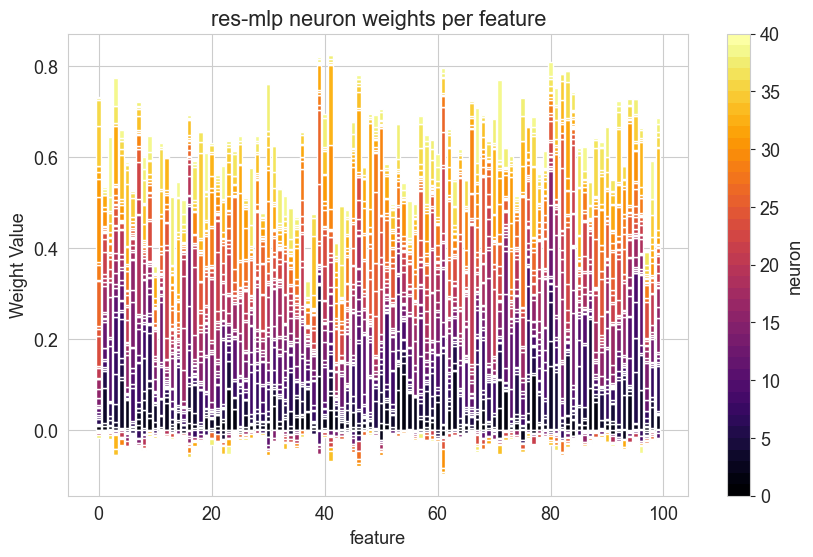

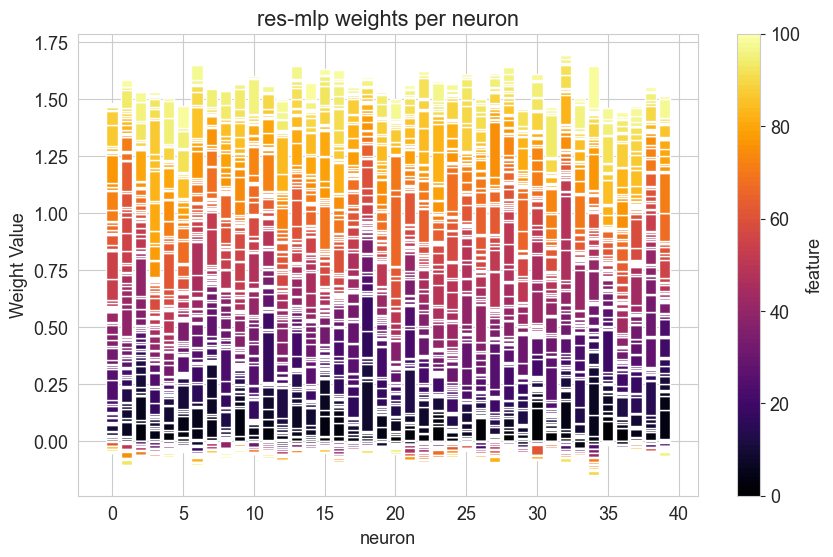

In [155]:
"""Plot weights for neurons per feature, and for features per neuron."""

l1_weights = threshold_matrix(asnumpy(res_mlp.W1).squeeze(), threshold=0.01)
l1_weights = einsum(l1_weights, asnumpy(res_mlp.We.squeeze()), "neuron emb, emb feat-> neuron feat")
l2_weights = threshold_matrix(asnumpy(res_mlp.W2).squeeze(), threshold=0.01)
l2_weights = einsum(asnumpy(res_mlp.Wu.squeeze()), l2_weights, "feat emb, emb neuron-> feat neuron")

l1_weights = einsum(l1_weights, l2_weights, "neuron feature, feature neuron-> neuron feature")

print(f"{l1_weights.shape=}")

fig = plot_weight_bars(l1_weights, xax="feature")
fig.get_axes()[0].set_title("res-mlp neuron weights per feature")

fig = plot_weight_bars(l1_weights.T, xax="neuron")
fig.get_axes()[0].set_title("res-mlp weights per neuron")

## tms-cis